<a href="https://colab.research.google.com/github/ricardoloureirosoares/introducaoaojavascript/blob/main/analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas nltk spacy matplotlib seaborn wordcloud scikit-learn

In [ ]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 31.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import nltk
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
# 1. CARREGAR DADOS (CSVs)
from google.colab import drive
drive.mount('/content/drive')

df_likert = pd.read_csv('/content/drive/MyDrive/analise/respostas_likert_QDA_Miner.csv')
df_abertas = pd.read_csv('/content/drive/MyDrive/analise/questoes_abertas_QDA_Miner.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Lista o conteúdo do seu Google Drive (Meu Drive)
# O erro indica que a pasta 'analise' não foi encontrada neste caminho.
# Vamos listar o conteúdo do diretório pai para verificar o nome correto da pasta.
try:
    print(os.listdir('/content/drive/MyDrive/'))
except FileNotFoundError:
    print("Não foi possível acessar o '/content/drive/MyDrive/'. Certifique-se de que o Google Drive está montado corretamente.")


['Colab Notebooks', 'Classroom', 'Tabela 3.7.3.6.ods', 'Tabela 3.7.3.6.gsheet', 'Trabalho1 - Tópicos em Inteligência Computacional.gdoc', 'Pré-Projeto - Ricardo.gdoc', 'MESTRADO', 'Relatório.gdoc', 'PRÉ-PROJETO PESQUISA - TGD.gdoc', 'Keywords.gdoc', 'Fichamento legislações TGD no Brasil.gdoc', 'QUADRO 1 – Leis que amparam as pessoas com deficiência no Brasil.gdoc', '(atualizado em 18-06-2023) - ARTIGO - INCLUSÃO DE CRIANÇAS COM DEFICIÊNCIA NO ENSINO MÉDIO.docx - Gráfico de barras 1.gsheet', 'Cópia de Indicador 9 | Taxa de distorção idade-série.csv', 'Tabela 1 - Quadro comparativo das legislações.gsheet', 'Planilha sem título (2).gsheet', 'Modelagem de Regressão.gdoc', 'Autismo no Brasil: uma revisão sistemática dos desafios familiares e estratégias de enfrentamento.gdoc', '"Análise de Regressão das Políticas Públicas para a Inclusão de Deficientes nas Escolas Brasileiras".gdoc', 'AS POLÍTICAS PÚBLICAS DE EDUCAÇÃO INCLUSIVA.docx', 'A inclusão escolar é

Você também pode listar o conteúdo de uma subpasta específica, como 'QDA_Miner' se o seu arquivo estivesse lá:


In [ ]:
import os

try:
    print(os.listdir('/content/drive/MyDrive/analise/'))
except FileNotFoundError:
    print("Não foi possível acessar a pasta '/content/drive/MyDrive/analise/'. Por favor, verifique se o nome da pasta está correto.")

['analise.ipynb', 'codigos_tematicos_QDA_Miner.csv', 'exemplo_codificacao_QDA_Miner.csv', 'questoes_abertas_QDA_Miner.csv', 'respostas_likert_QDA_Miner.csv', '.ipynb_checkpoints']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# 2. ANÁLISE QUANTITATIVA (respostas Likert)
print("=== ESTATÍSTICAS LIKERT ===")
print(df_likert.describe())  # Média, desvio padrão, etc.

=== ESTATÍSTICAS LIKERT ===
       Resposta_Likert
count        40.000000
mean          4.125000
std           0.722797
min           2.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000


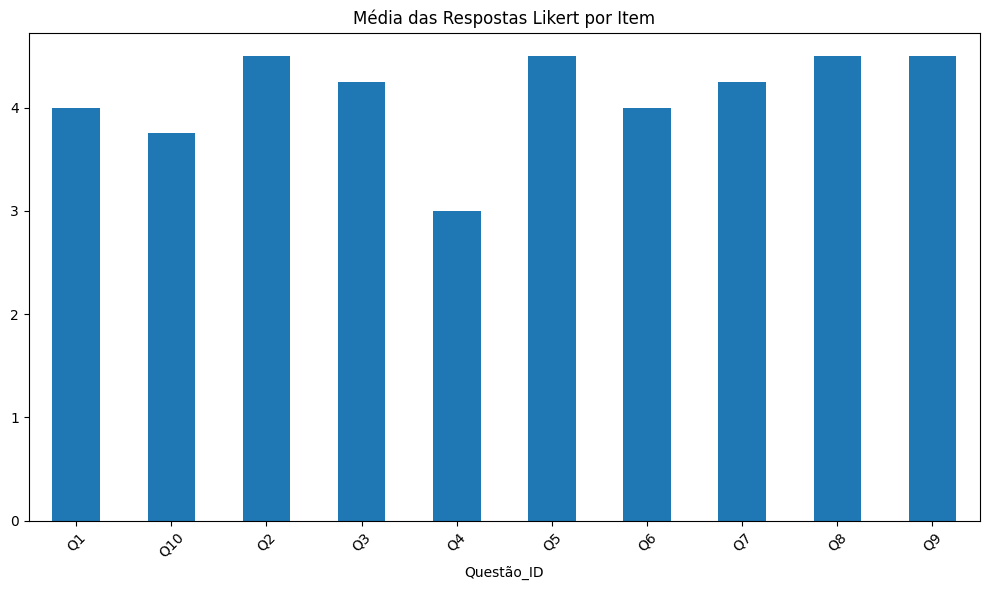

In [ ]:
# Gráfico de barras Likert
plt.figure(figsize=(10,6))
df_likert.groupby('Questão_ID')['Resposta_Likert'].mean().plot(kind='bar')
plt.title('Média das Respostas Likert por Item')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('likert_medias.png', dpi=300)
plt.show()

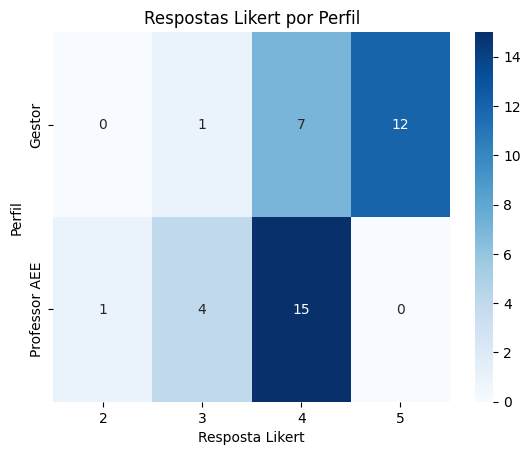

In [ ]:
# Crosstab (comparar por perfil)
crosstab = pd.crosstab(df_likert['Perfil'], df_likert['Resposta_Likert'])
sns.heatmap(crosstab, annot=True, cmap='Blues', fmt='d')
plt.title('Respostas Likert por Perfil')
plt.xlabel('Resposta Likert')
plt.ylabel('Perfil')
plt.savefig('crosstab_perfil.png', dpi=300)
plt.show()

Palavras mais frequentes:
escola: 9
família: 6
histórico: 5
ficar: 5
atendimento: 5
estudante: 4
professor: 4
informação: 4
ter: 4
aluno: 3
tea: 3
rapidamente: 3
progresso: 3
desenvolvimento: 3
filho: 3
preciso: 3
real: 3
muito: 3
precisar: 3
saber: 3


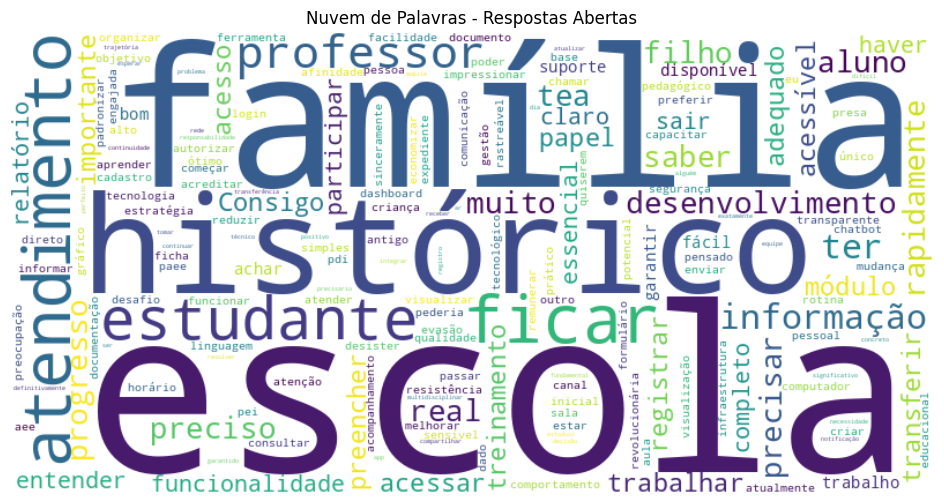

In [ ]:
# 3. ANÁLISE QUALITATIVA (textos abertos)
nlp = spacy.load("pt_core_news_sm")

# Limpeza e tokenização
def preprocess_text(texto):
    doc = nlp(texto.lower())
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

df_abertas['texto_limpo'] = df_abertas['Resposta_Transcrita'].apply(preprocess_text)

# Frequência de palavras
all_words = ' '.join(df_abertas['texto_limpo']).split()
word_freq = Counter(all_words)
#print("Palavras mais frequentes:", word_freq.most_common(20))
print("Palavras mais frequentes:")
for palavra, freq in word_freq.most_common(20):
    print(f"{palavra}: {freq}")


# Nuvem de palavras (equivalente ao code cloud do QDA)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_abertas['texto_limpo']))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuvem de Palavras - Respostas Abertas')
plt.savefig('nuvem_palavras.png', dpi=300)
plt.show()

In [ ]:
# 4. CODIFICAÇÃO TEMÁTICA AUTOMÁTICA (equivalente ao codebook)
# Carrega os códigos temáticos e suas palavras-chave
df_codigos = pd.read_csv('/content/drive/MyDrive/analise/codigos_tematicos_QDA_Miner.csv')

codigos_keywords = {}
for index, row in df_codigos.iterrows():
    code = row['Código']
    keywords_str = row['Exemplos_Palavras-Chave']
    if pd.notna(keywords_str):
        # Remove espaços em branco e divide por vírgula
        keywords = [kw.strip().lower() for kw in keywords_str.split(',') if kw.strip()]
        codigos_keywords[code] = keywords
    else:
        codigos_keywords[code] = [] # Se não houver palavras-chave, atribui uma lista vazia

def codificar_texto(texto, codigos_keywords_map):
    """Atribui códigos temáticos baseado em palavras-chave"""
    codigos_encontrados = []
    texto_lower = texto.lower()
    for codigo, keywords in codigos_keywords_map.items():
        for keyword in keywords:
            if keyword in texto_lower:
                codigos_encontrados.append(codigo)
                break # Adiciona o código uma vez se qualquer palavra-chave for encontrada
    return codigos_encontrados

df_abertas['codigos'] = df_abertas['Resposta_Transcrita'].apply(lambda x: codificar_texto(x, codigos_keywords))

# Frequência de códigos (equivalente ao Coding Frequency do QDA)
from collections import defaultdict
freq_codigos = defaultdict(int)
for codigos_list in df_abertas['codigos']:
    for codigo in codigos_list:
        freq_codigos[codigo] += 1

print("Frequência de Códigos:\n" + str(freq_codigos).replace(', ', ',\n'))

Frequência de Códigos:
defaultdict(<class 'int'>,
{'USB_Facilidade_Navegação': 4,
'USB_Organização_Interface': 2,
'FUNC_Cadastro_Estudantes': 4,
'FUNC_Dashboard_Métricas': 3,
'COM_Transparência_Informações': 9,
'SEG_Controle_Acesso': 3,
'IMP_Continuidade_Pedagógica': 6,
'IMP_Melhoria_Atendimento': 9,
'USB_Acessibilidade': 5,
'FUNC_Chatbot_IA': 14,
'DES_Resistência_Mudança': 1,
'COM_Comunicação_Profissionais': 2,
'COM_Participação_Família': 5,
'COM_Notificações': 4,
'FUNC_Registros_Atendimentos': 6,
'DES_Capacitação_Treinamento': 3,
'REC_Linguagem_Acessível': 3,
'IMP_Redução_Tempo': 5,
'SEG_Proteção_Dados': 1,
'SEG_Conformidade_LGPD': 1,
'DES_Integração_Sistemas': 1,
'REC_Horário_Treinamento': 3,
'DES_Suporte_Técnico': 2,
'FUNC_Documentos_Pedagógicos': 1,
'DES_Infraestrutura_Tecnológica': 1,
'REC_App_Mobile': 1,
'REC_Integração_Rede': 1})


In [ ]:
# 5. MODELAGEM DE TÓPICO (temas automáticos - LDA)
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') # Garante que as stopwords estão baixadas
stop_words_pt = stopwords.words('portuguese')

vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words_pt)
X = vectorizer.fit_transform(df_abertas['texto_limpo'])

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

df_abertas['cluster'] = clusters
print("\nDistribuição dos clusters:")
print(df_abertas['cluster'].value_counts())

# 6. EXPORTAR RESULTADOS
df_resultados = df_abertas[['Resposta_Transcrita', 'codigos', 'cluster']].copy()
df_resultados.to_csv('resultados_codificacao.csv', index=False)
print("Resultados exportados para 'resultados_codificacao.csv'")


Distribuição dos clusters:
cluster
1    6
0    4
2    2
4    2
3    2
Name: count, dtype: int64
Resultados exportados para 'resultados_codificacao.csv'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print("\nAnálise dos Clusters (Top 10 termos por cluster):")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f' - {terms[ind]}')
    print()


Análise dos Clusters (Top 10 termos por cluster):
Cluster 0:
 - preciso
 - treinamento
 - adequado
 - funcionalidade
 - remunerar
 - horário
 - infraestrutura
 - sinceramente
 - expediente
 - tecnológico

Cluster 1:
 - atendimento
 - escola
 - histórico
 - aluno
 - professor
 - estudante
 - transferir
 - saber
 - consigo
 - módulo

Cluster 2:
 - família
 - filho
 - ficar
 - reduzir
 - comunicação
 - evasão
 - aula
 - direto
 - canal
 - comportamento

Cluster 3:
 - suporte
 - sair
 - disponível
 - essencial
 - precisar
 - começar
 - base
 - trabalhar
 - completo
 - bom

Cluster 4:
 - família
 - relatório
 - entender
 - claro
 - participar
 - concreto
 - atualizar
 - positivo
 - decisão
 - definitivamente



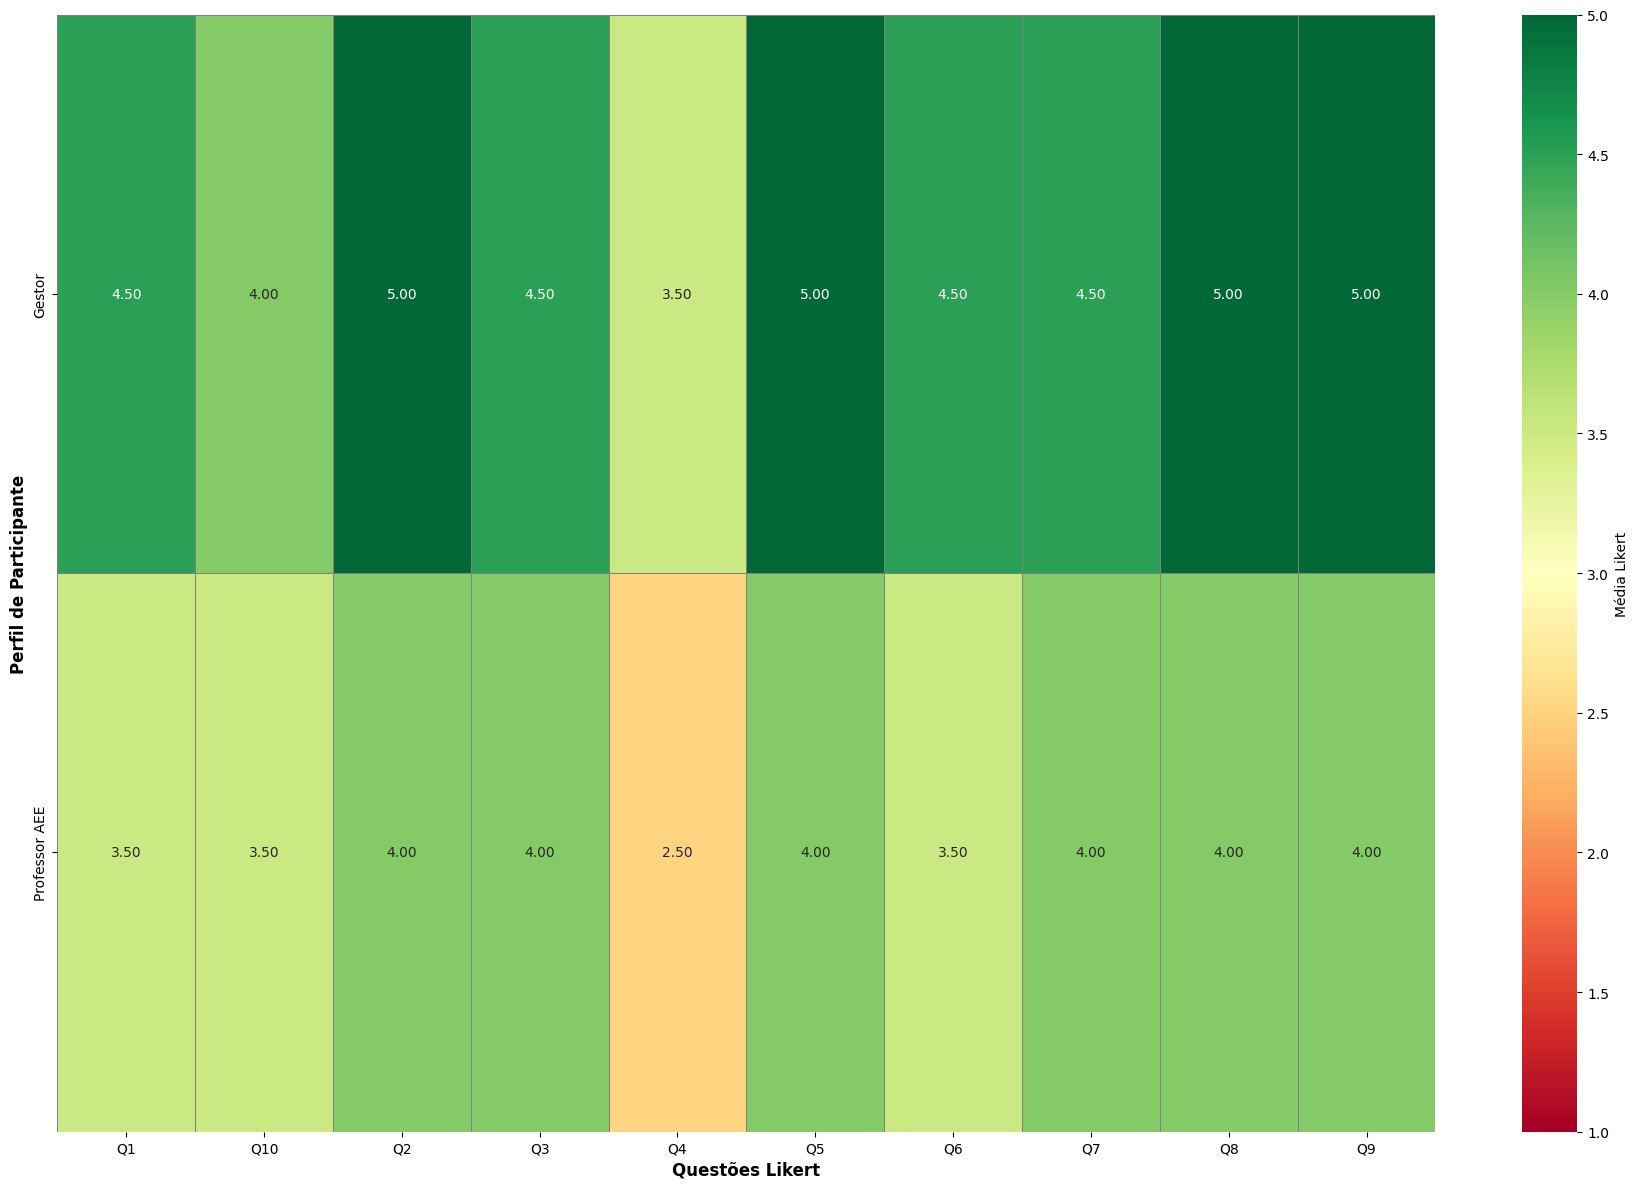

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pivot_data = df_likert.groupby('Perfil')['Resposta_Likert'].mean().reset_index() # Calcula a média apenas para 'Resposta_Likert'

pivot_data = df_likert.pivot_table(index='Perfil', columns='Questão_ID', values='Resposta_Likert', aggfunc='mean')

fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn',
            center=3, vmin=1, vmax=5, cbar_kws={'label': 'Média Likert'},
            ax=ax, linewidths=0.5, linecolor='gray')
ax.set_xlabel('Questões Likert', fontsize=12, fontweight='bold')
ax.set_ylabel('Perfil de Participante', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('figura_3_respostas_por_perfil.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
for i in range(kmeans.n_clusters):
    print(f"\n--- Cluster {i} ---")
    cluster_responses = df_abertas[df_abertas['cluster'] == i]['Resposta_Transcrita']
    for j, response in enumerate(cluster_responses):
      print(f"  Resposta {j+1}:\n{response}")





--- Cluster 0 ---
  Resposta 1:
A facilidade de registrar os atendimentos é ótima. Não preciso preencher formulários em papel e depois passar para o computador. Tudo em tempo real. O chatbot educacional também chamou minha atenção como ferramenta de apoio.
  Resposta 2:
Minha preocupação é com a segurança dos dados das crianças. Preciso ter certeza de que apenas pessoas autorizadas acessarão essas informações sensíveis. Além disso, preciso de treinamento adequado para usar todas as funcionalidades.
  Resposta 3:
Todas as funcionalidades são bem pensadas. Mas para mim, a gestão de documentos pedagógicos é revolucionária. PEI, PAEE, PDI - tudo padronizado, organizado, rastreável. Economiza muito tempo e garante qualidade na documentação.
  Resposta 4:
Sinceramente, acho que seria bem fácil. Nossa escola já tem infraestrutura tecnológica adequada. O que pederia seria fazer treinamento em horário de trabalho, não fora do expediente. Precisamos de tempo remunerado para aprender.

--- Clust

In [ ]:
from collections import defaultdict

print("\n--- Frequência de Códigos Temáticos por Cluster ---")
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i}:/n")
    cluster_df = df_abertas[df_abertas['cluster'] == i]

    # Coleta todos os códigos para este cluster
    cluster_codigos = defaultdict(int)
    for codigos_list in cluster_df['codigos']:
        for codigo in codigos_list:
            cluster_codigos[codigo] += 1

    # Ordena os códigos por frequência e imprime
    if cluster_codigos:
        sorted_codigos = sorted(cluster_codigos.items(), key=lambda item: item[1], reverse=True)
        for codigo, freq in sorted_codigos:
            print(f"  - {codigo}: {freq}")
    else:
        print("  Nenhum código temático encontrado para este cluster.")


--- Frequência de Códigos Temáticos por Cluster ---

Cluster 0:/n
  - FUNC_Chatbot_IA: 4
  - IMP_Redução_Tempo: 3
  - FUNC_Cadastro_Estudantes: 2
  - IMP_Melhoria_Atendimento: 2
  - DES_Capacitação_Treinamento: 2
  - REC_Horário_Treinamento: 2
  - FUNC_Registros_Atendimentos: 1
  - COM_Notificações: 1
  - COM_Transparência_Informações: 1
  - SEG_Proteção_Dados: 1
  - SEG_Conformidade_LGPD: 1
  - DES_Integração_Sistemas: 1
  - FUNC_Documentos_Pedagógicos: 1
  - USB_Facilidade_Navegação: 1
  - DES_Infraestrutura_Tecnológica: 1

Cluster 1:/n
  - IMP_Melhoria_Atendimento: 5
  - COM_Transparência_Informações: 4
  - IMP_Continuidade_Pedagógica: 4
  - FUNC_Chatbot_IA: 4
  - FUNC_Registros_Atendimentos: 4
  - USB_Facilidade_Navegação: 2
  - FUNC_Cadastro_Estudantes: 2
  - SEG_Controle_Acesso: 2
  - USB_Acessibilidade: 2
  - USB_Organização_Interface: 1
  - FUNC_Dashboard_Métricas: 1
  - DES_Resistência_Mudança: 1
  - COM_Participação_Família: 1
  - DES_Capacitação_Treinamento: 1
  - REC_Lingu


--- Média Likert por Perfil dentro de Cada Cluster ---

Cluster 0:
          Perfil  Resposta_Likert
0         Gestor              4.8
1  Professor AEE              3.5


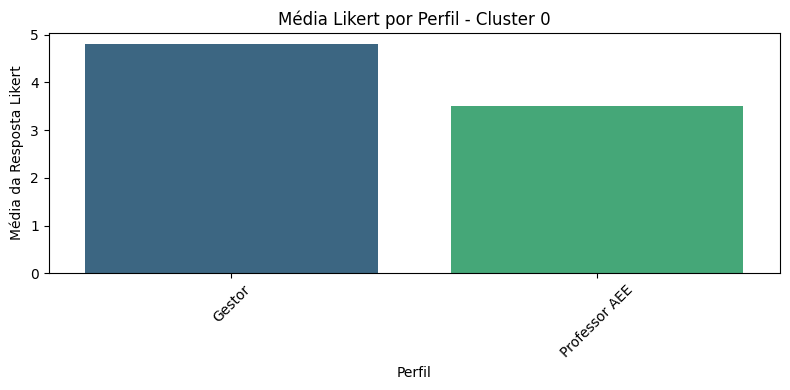


Cluster 1:
          Perfil  Resposta_Likert
0         Gestor              4.3
1  Professor AEE              3.9


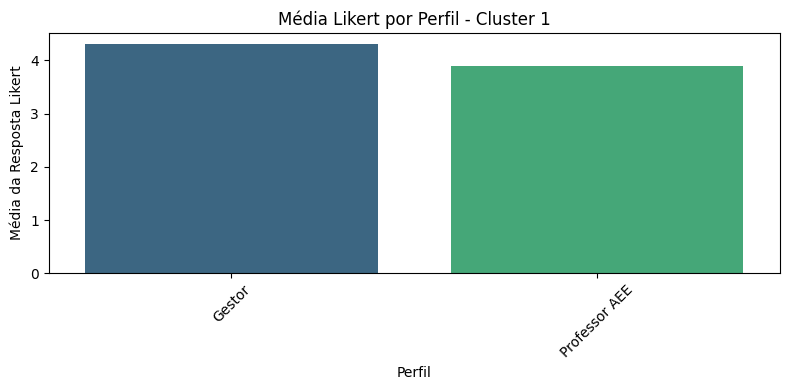


Cluster 2:
  Nenhum dado de Likert associado a perfis neste cluster.

Cluster 3:
  Nenhum dado de Likert associado a perfis neste cluster.

Cluster 4:
  Nenhum dado de Likert associado a perfis neste cluster.


In [ ]:
participant_clusters = df_abertas.groupby('Participante_ID')['cluster'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).reset_index()
participant_clusters.rename(columns={'cluster': 'dominant_cluster'}, inplace=True)

# Agora, mesclamos essa informação de cluster dominante com o DataFrame df_likert
df_likert_com_cluster = pd.merge(df_likert, participant_clusters, on='Participante_ID', how='left')
# Renomeamos a coluna 'dominant_cluster' para 'cluster' para que o código original funcione sem alterações
df_likert_com_cluster.rename(columns={'dominant_cluster': 'cluster'}, inplace=True)


print("\n--- Média Likert por Perfil dentro de Cada Cluster ---")

for i in range(kmeans.n_clusters):
    print(f"\nCluster {i}:")

    # Filtra o DataFrame para o cluster atual
    cluster_df = df_likert_com_cluster[df_likert_com_cluster['cluster'] == i]

    # Calcula a média Likert por perfil dentro deste cluster
    mean_likert_by_perfil = cluster_df.groupby('Perfil')['Resposta_Likert'].mean().reset_index()

    if not mean_likert_by_perfil.empty:
        print(mean_likert_by_perfil)
    else:
        print("  Nenhum dado de Likert associado a perfis neste cluster.")

    # Opcional: Visualizar com um barplot para cada cluster (se houver muitos clusters, pode ficar sobrecarregado)
    if not mean_likert_by_perfil.empty and len(mean_likert_by_perfil['Perfil'].unique()) > 1:
        plt.figure(figsize=(8, 4))
        sns.barplot(x='Perfil', y='Resposta_Likert', hue='Perfil', data=mean_likert_by_perfil, palette='viridis', legend=False)
        plt.title(f'Média Likert por Perfil - Cluster {i}')
        plt.xlabel('Perfil')
        plt.ylabel('Média da Resposta Likert')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'likert_perfil_cluster_{i}.png', dpi=300)
        plt.show()
    elif not mean_likert_by_perfil.empty:
        print(f"  Não há variação de perfil suficiente para um gráfico de barras no Cluster {i}.")

<IPython.core.display.Javascript object>

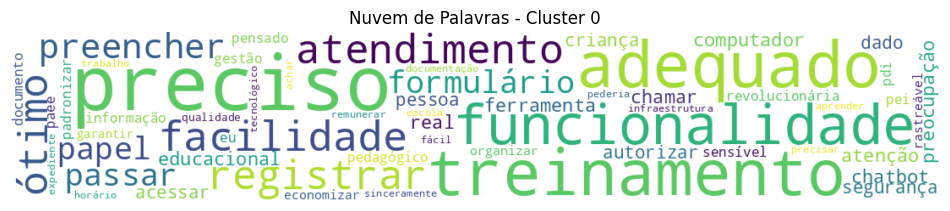

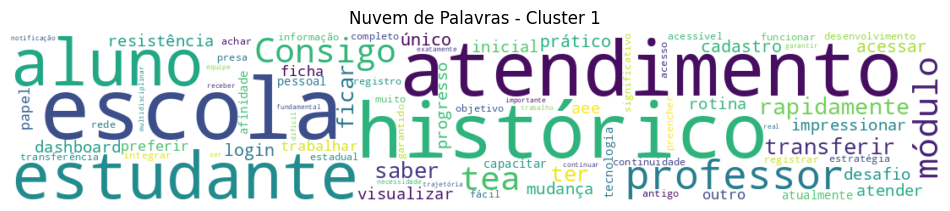

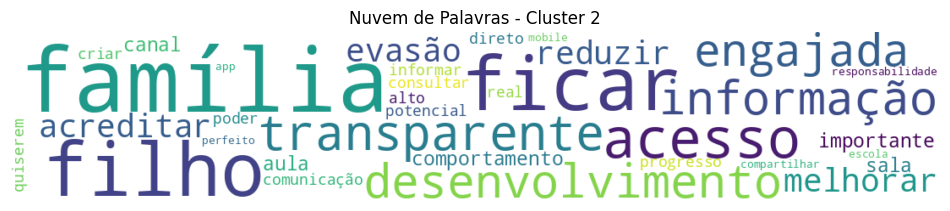

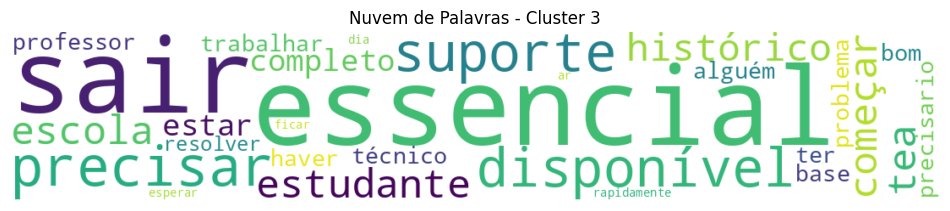

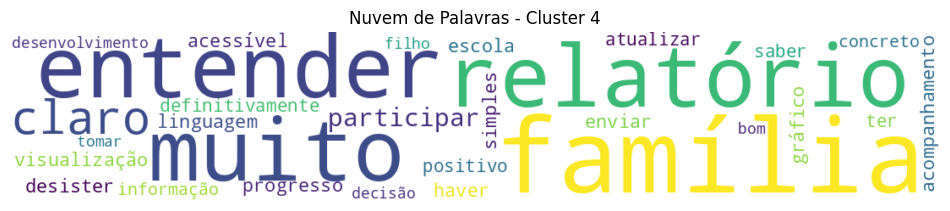

In [ ]:
from google.colab import output
output.no_vertical_scroll()

for i in range(kmeans.n_clusters):
    cluster_texts = ' '.join(df_abertas[df_abertas['cluster'] == i]['texto_limpo'])
    if cluster_texts:
        wordcloud = WordCloud(width=1100, height=200, background_color='white').generate(cluster_texts)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Nuvem de Palavras - Cluster {i}')
        plt.savefig(f'nuvem_palavras_cluster_{i}.png', dpi=300)
        plt.show()
    else:
        print(f"Não há texto limpo para o Cluster {i}.")

In [ ]:
df_likert_perfil_cluster = df_likert_com_cluster.groupby(['Perfil', 'cluster'])['Resposta_Likert'].mean().reset_index()
print("DataFrame df_likert_perfil_cluster:")
print(df_likert_perfil_cluster.head())

DataFrame df_likert_perfil_cluster:
          Perfil  cluster  Resposta_Likert
0         Gestor        0              4.8
1         Gestor        1              4.3
2  Professor AEE        0              3.5
3  Professor AEE        1              3.9


In [ ]:
import plotly.express as px

# Calculate mean_likert_by_cluster
mean_likert_by_cluster = df_likert_com_cluster.groupby('cluster')['Resposta_Likert'].mean().reset_index()

# 1. Gráfico de barras interativo: Média das Respostas Likert por Cluster
fig1 = px.bar(
    mean_likert_by_cluster,
    x='cluster',
    y='Resposta_Likert',
    title='Média das Respostas Likert por Cluster'
)
fig1.show()

# 2. Gráfico de barras interativo: Média das Respostas Likert por Perfil dentro de Cada Cluster
fig2 = px.bar(
    df_likert_perfil_cluster,
    x='cluster',
    y='Resposta_Likert',
    color='Perfil',
    barmode='group',
    title='Média das Respostas Likert por Perfil dentro de Cada Cluster'
)
fig2.show()

### Gráfico de Barras Personalizado: Média das Respostas Likert por Item

Mounted at /content/drive


/tmp/ipython-input-3470147585.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




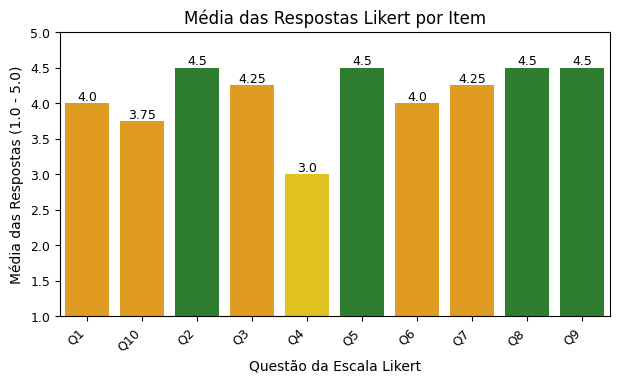

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assegura que df_likert está carregado
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df_likert = pd.read_csv('/content/drive/MyDrive/analise/respostas_likert_QDA_Miner.csv')

# 1. Calcular a média das respostas Likert por Questão_ID
mean_likert_by_question = df_likert.groupby('Questão_ID')['Resposta_Likert'].mean().reset_index()

# 2. Definir a função para mapear cores
def get_bar_color(mean_value):
    if mean_value >= 4.5: # Alterado de > para >=
        return 'forestgreen' # Verde escuro
    elif 3.0 <= mean_value <= 3.5:
        return 'gold'      # Amarelo
    elif mean_value < 2.5:
        return 'firebrick' # Vermelho
    else:
        return 'orange'    # Cor intermediária para 3.5 < mean < 4.5 ou 2.5 <= mean < 3.0

# Mapear cores para cada barra
colors = [get_bar_color(mean) for mean in mean_likert_by_question['Resposta_Likert']]

# Converter cm para polegadas para figsize
width_cm = 16
height_cm = 10
width_inches = width_cm / 2.54
height_inches = height_cm / 2.54

plt.figure(figsize=(width_inches, height_inches))
sns.barplot(x='Questão_ID', y='Resposta_Likert', data=mean_likert_by_question, palette=colors)

# Ajustar fonte
plt.rcParams['font.family'] = 'sans-serif' # Tenta usar uma fonte sem serifa como Arial/Calibri
plt.rcParams['font.sans-serif'] = ['Arial', 'Calibri', 'DejaVu Sans'] # Lista de fontes, fallback
plt.rcParams['font.size'] = 10

plt.title('Média das Respostas Likert por Item', fontsize=12) # Título um pouco maior para destaque
plt.xlabel('Questão da Escala Likert', fontsize=10)
plt.ylabel('Média das Respostas (1.0 - 5.0)', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=9) # Rotaciona e alinha os rótulos do X
plt.yticks(fontsize=9)
plt.ylim(1.0, 5.0) # Garante que o eixo Y vá de 1 a 5

# Adicionar o valor numérico da média no topo de cada barra
for index, row in mean_likert_by_question.iterrows():
    plt.text(index, row['Resposta_Likert'], round(row['Resposta_Likert'], 2),
             color='black', ha="center", va='bottom', fontsize=9)

plt.tight_layout() # Ajusta o layout para evitar cortes
plt.savefig('likert_media_por_item_customizado.png', dpi=300)
plt.show()

Este gráfico de barras personalizado oferece uma visualização detalhada e colorida da média das respostas Likert para cada item, facilitando a identificação rápida de pontos fortes e fracos conforme os critérios de cores definidos.

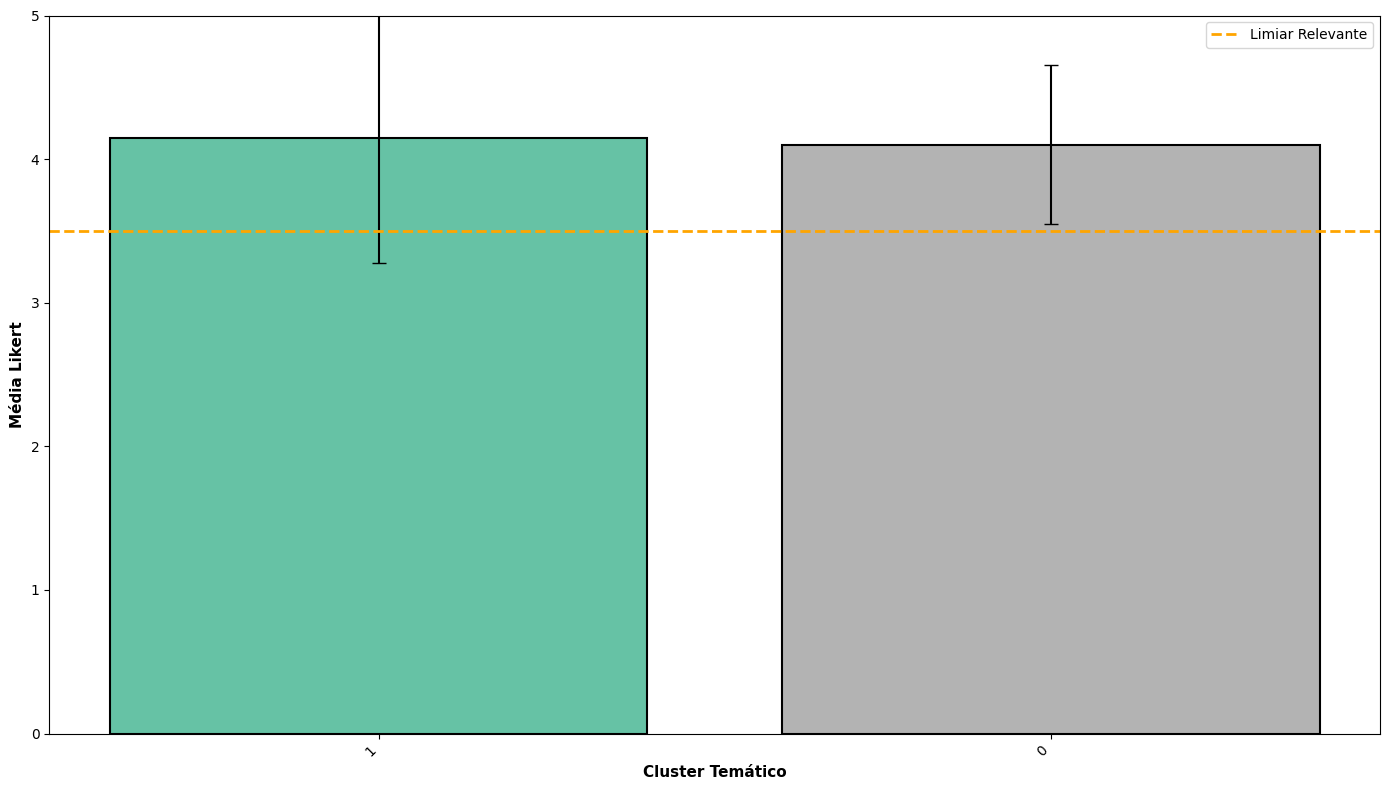

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suponha df_likert com coluna 'cluster' identificando cluster de cada questão
# Usar df_likert_com_cluster que contém a coluna 'cluster' para as respostas Likert
clusters = df_likert_com_cluster['cluster'].unique()
medias_cluster = []
desvios_cluster = []

for cluster in sorted(clusters):
    # Filtrar df_likert_com_cluster pelo cluster atual e selecionar apenas a coluna de Resposta_Likert
    dados_cluster = df_likert_com_cluster[df_likert_com_cluster['cluster'] == cluster]['Resposta_Likert']
    media = dados_cluster.mean()
    desvio = dados_cluster.std()
    medias_cluster.append(media)
    desvios_cluster.append(desvio)

fig, ax = plt.subplots(figsize=(14, 8))
x_pos = np.arange(len(clusters))
cores = plt.cm.Set2(np.linspace(0, 1, len(clusters)))
ax.bar(x_pos, medias_cluster, yerr=desvios_cluster, capsize=5,
       color=cores, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Cluster Temático', fontsize=11, fontweight='bold')
ax.set_ylabel('Média Likert', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(clusters, rotation=45, ha='right')
ax.set_ylim(0, 5)
ax.axhline(y=3.5, color='orange', linestyle='--', linewidth=2, label='Limiar Relevante')
ax.legend()
plt.tight_layout()
plt.savefig('grafico_3_media_por_cluster.png', dpi=300, bbox_inches='tight')
plt.show()